**Abdullah Ash Saki**  
Enabling Quantum Technologies Researcher @ IBM Quantum

- **Co-authors**: *Pedro Rivero, Ritajit Majumdar, Haimeng Zhang*
- **Collaborators**: *Drew Vandeth, Mirko Amico, Nate Earnest-Noble, Borja Peropadre*

# Scale quantum computational workflows

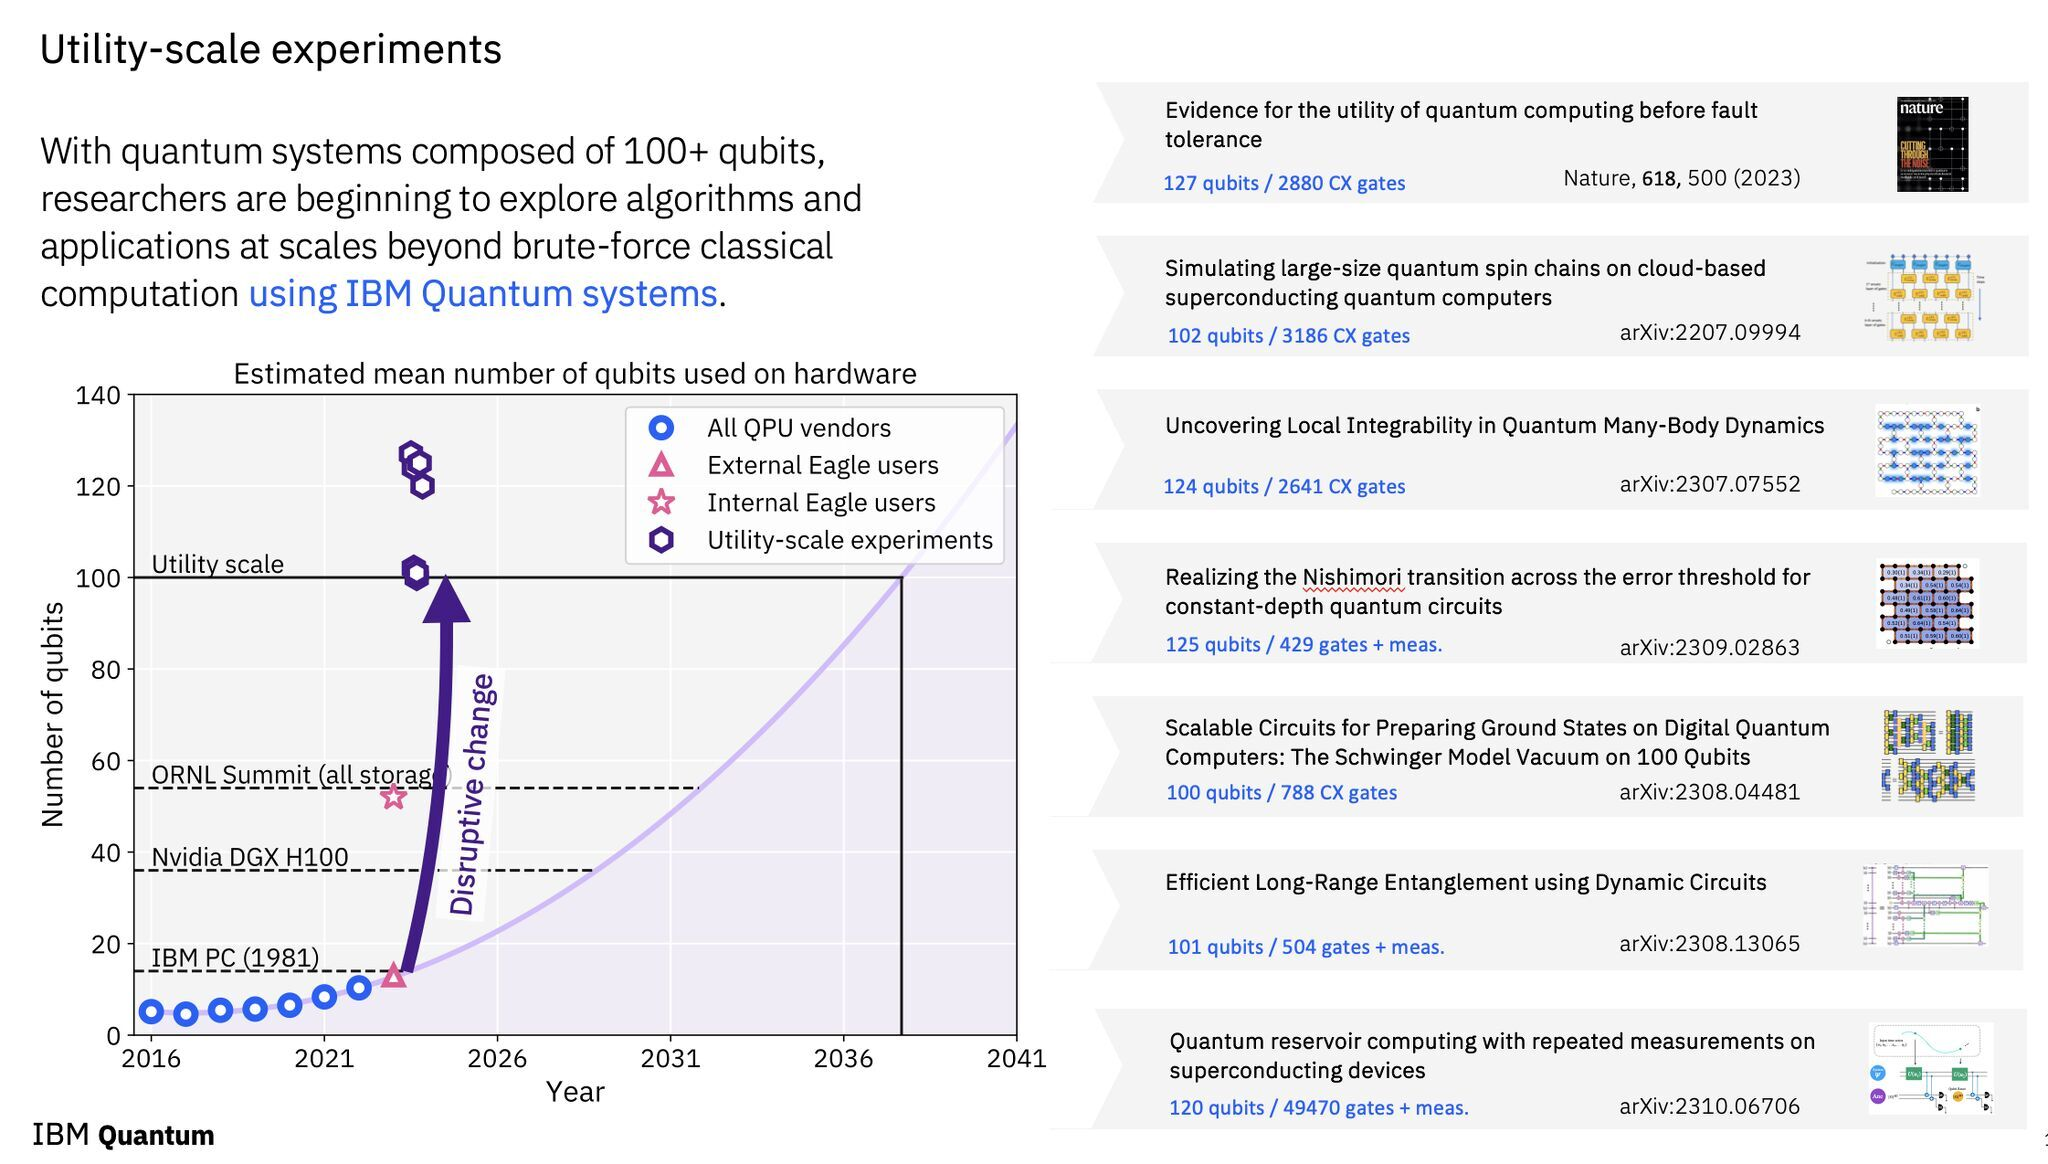

## Step 1: Generate quantum circuits

The circuits that we are going to explore in this notebook are meant to showcase how some relevant quantum pipelines can be scaled. To this end, we will begin studying different _hardware-native_ quantum circuits tied to the widely spread task of Hamiltonian simulation: 
- Quantum approximate optimization algorithm (QAOA)
- Transverse-field Ising model dynamics (TFIM)
- Many-body localization (MBL)

Due to the systems being described, these circuits will turn out equivalent in practice.

Then we will introduce a derivative form of the above circuits in order to address result validation: _mirror circuits_ following a compute-uncompute pattern (i.e. $U^\dagger U$). Finally, we will build our target virtual circuit to be executed at a given scale.

### Quantum approximate optimization algorithm (QAOA)

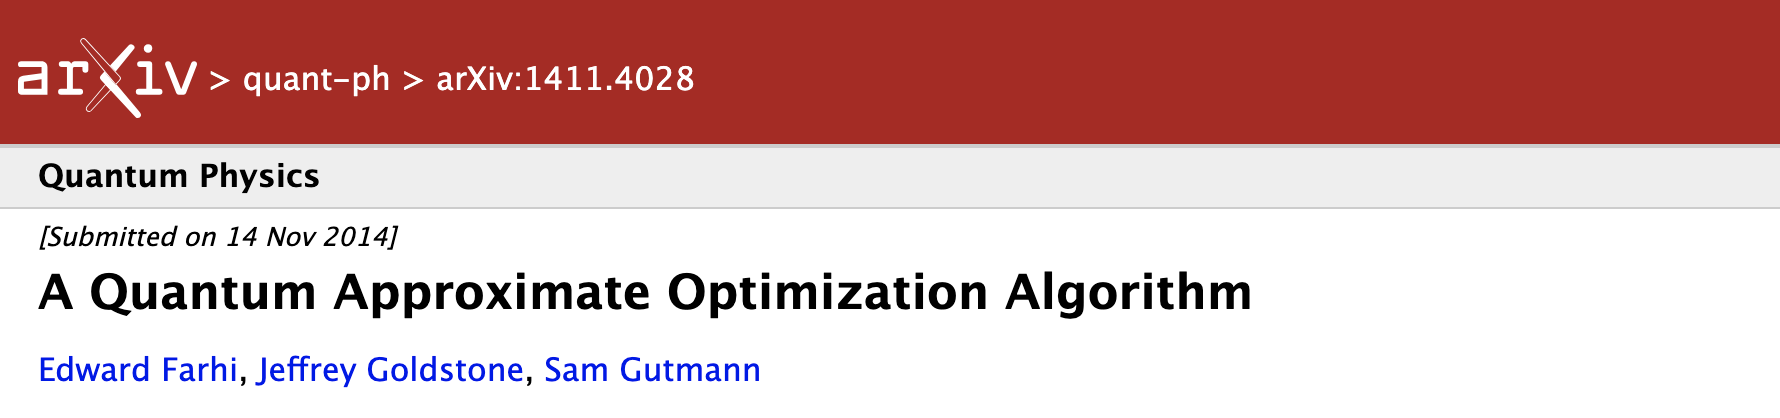

The first circuit candidate in our list is a [QAOA circuit](https://arxiv.org/abs/1411.4028) for a _MaxCut_ problem on a linear, acyclic, graph. 

This kind of graph ensures that the two-qubit density per layer will be almost as large as theoretically possible (see appendices), missing only one possible two-qubit gate every other layer which corresponds to connecting the first and last nodes of the graph. The reason why we refrain from doing so is so that the circuit remains _hardware-native_ regardless of the number of qubits (i.e. directly mappable onto the heavy-hex architecture of the latest IBM's quantum backends). Otherwise, auxiliry SWAP layers would need to be inserted, increasing the depth and reducing the overall two-qubit gate density without any gains towards more valuable results from a computational standpoint.

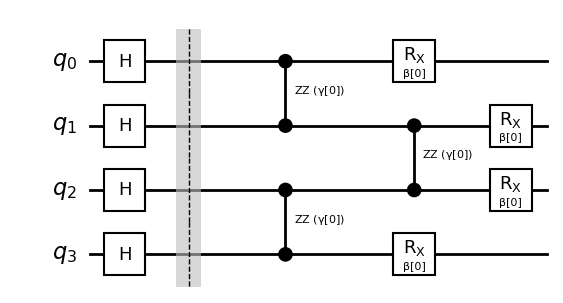

In [1]:
from quantum_enablement.circuits import QAOAPathCircuit

reference_circuit = QAOAPathCircuit(num_qubits=4, depth=2, barriers=True, measurements=False)

reference_circuit.draw("mpl", style="bw")

### Transverse-field Ising model dynamics (TFIM)

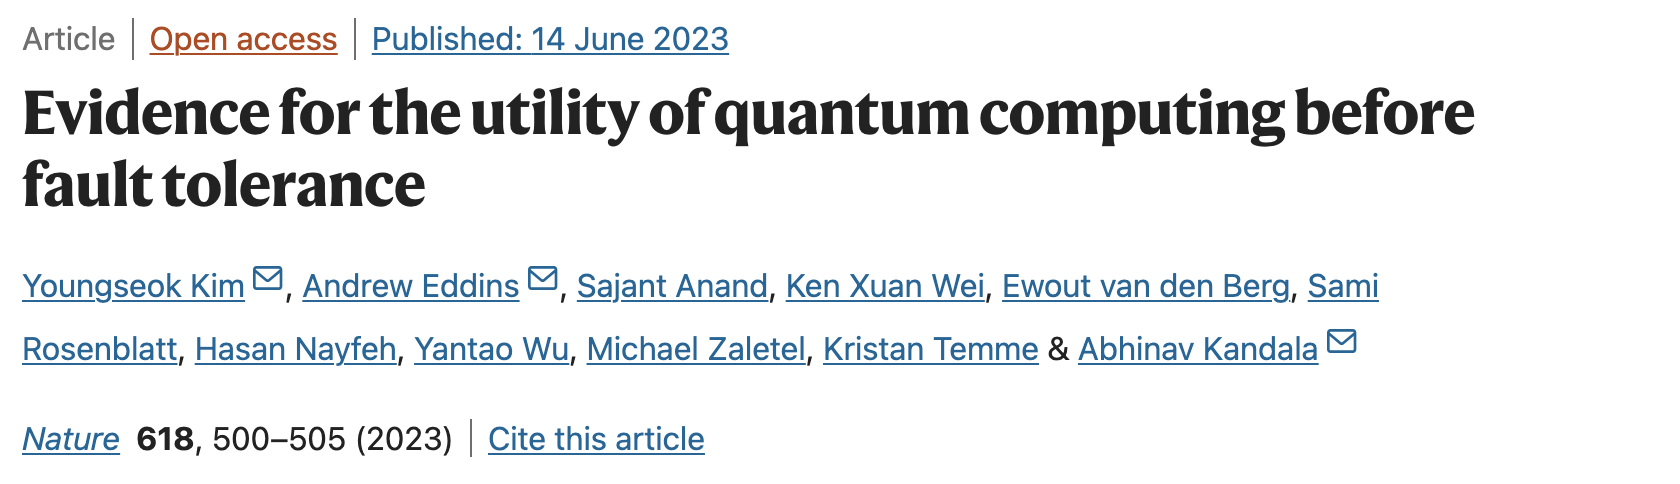

By construction, the previous QAOA circuit also represents the dynamics of a spin chain as pictured by the one-dimensional _transverse-field Ising model_ (TFIM) without periodic boundary conditions. The physics of this problem were studied in the [recent utility work](https://doi.org/10.1038/s41586-023-06096-3) by Kim et al.

### Many-body localization (MBL)

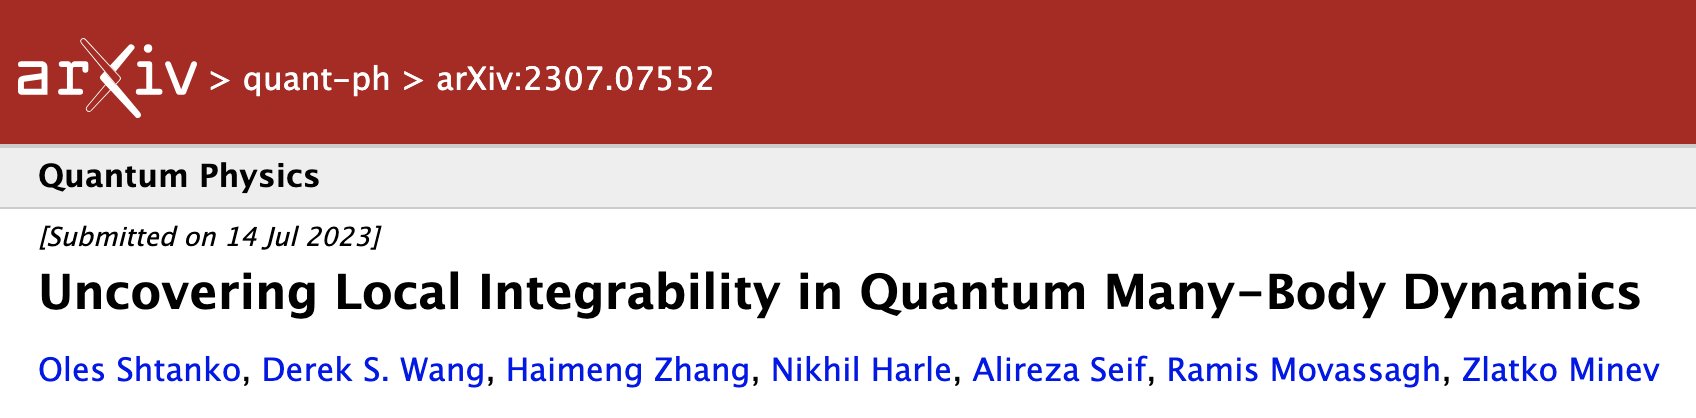

Another relevant circuit comes from [many-body localization (MBL)](https://www.youtube.com/watch?v=fWhmWbi-gaY), a mechanism by which disorder can stop thermalization. We will analyse a hardware-native one-dimensional realization as described in [recent work](https://arxiv.org/abs/2307.07552) by Shtanko et al.

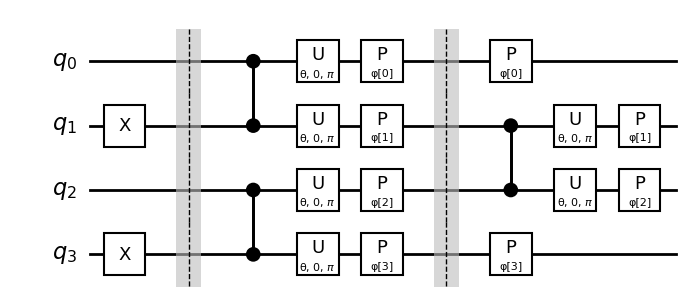

In [2]:
from quantum_enablement.circuits import MBLChainCircuit

reference_circuit = MBLChainCircuit(num_qubits=4, depth=2, barriers=True, measurements=False)

reference_circuit.draw("mpl", style="bw") 

Upon comparison, one realizes that this circuit looks very similar to the QAOA/TFIM one. Indeed, after transpilation the resulting physical circuits will be roughly indistinguishable from one another up to single qubit rotations which are to some extent random by construction. This justifies the study of only one of these circuits, since results will be naturally equivalent.

### Mirror circuits:  the compute-uncompute pattern

The problem with the previous circuits as they stand is that their final solution is in principle unknown, meaning that we do not have an understanding of whether the results that we get out of the quantum computer are good or not. This is a fundamental question that quantum computing faces as a field: how to _validate_ results beyond the reach of traditional methods.

As an active area of research, a number of tentative approaches exist; nonetheless, while they all have their merits, some would make our particular circuits too simple and not representative of the struggles faced by researchers (e.g. naive Cliffordization). For the purposes of this work, we are not going to try to find an overarching solution; instead, we will replace the previous circuits with derivatives that preserve the overall internal structure and richness, but whose final answer is trivially known and can be compared against. 

Concretely, we will use _mirror_ circuits made out of a first stage where the original circuit $\hat{U}$ is applied, and a second one where it is reversed $\hat{U}^\dagger$; following a _compute-uncompute_ pattern. The ideal outcome of such circuits will trivially be the input state $|0\rangle^{\otimes N}$, with expectation value one for any Pauli observable. These circuits will nonetheless pick up noise during the execution, which will distance their results from the ideal solution in ways that should be similar to those in the original circuit for equal number of qubits and two-qubit depth.

For execution, we also need to bind the circuit parameters to specific values and insert the desired measurements.

In [3]:
from qiskit import QuantumCircuit

def compute_uncompute(
    circuit: QuantumCircuit, *, barrier: bool = True, inplace: bool = False
) -> QuantumCircuit:
    """Build compute-uncompute version of input quantum circuit.

    Args:
        circuit: the original quantum circuit to build compute-uncompute version of.
        barrier: whether to insert a barrier between the compute and uncompute
            halves of the output circuit.
        inplace: if True, modify the input circuit. Otherwise make a copy.

    Returns:
        Compute-uncompute version of input quantum circuit with optional barrier.
    """
    if not isinstance(circuit, QuantumCircuit):
        raise TypeError(f"Invalid circuit type {type(circuit)}, expected <QuantumCircuit>.")
    inverse = circuit.inverse()
    if not inplace:
        circuit = circuit.copy()
    if barrier:
        circuit.barrier()
    circuit.compose(inverse, inplace=True)
    return circuit

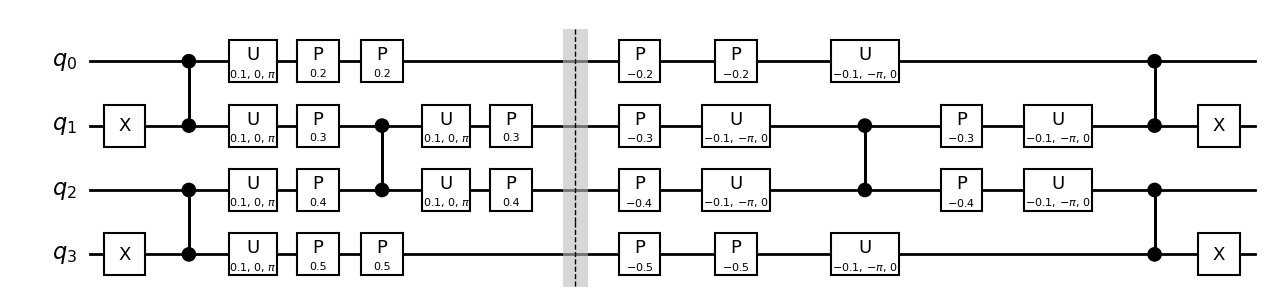

In [4]:
from quantum_enablement.circuits import MBLChainCircuit

reference_circuit = compute_uncompute(MBLChainCircuit(num_qubits=4, depth=2), barrier=True)
reference_circuit.assign_parameters([0.1, 0.2, 0.3, 0.4, 0.5], inplace=True)  # Note: dummy values

reference_circuit.draw("mpl", style="bw")

> **NOTICE:**
> 
> - Qiskit requires a *barrier* to be placed between the compute and uncompute parts of the circuit to avoid simplification over transpilation later on. 
> - Also, the depth of the circuits is doubled by the *compute-uncompute* construct.

In [5]:
def adds_two_qubit_depth(instruction):
    """Returns True if the instruction adds two-qubit depth, False otherwise."""
    if instruction.operation.name == "barrier":
        return False
    return instruction.operation.num_qubits > 1

depth = reference_circuit.depth(adds_two_qubit_depth)  # Original depth = 2
print(f">> Compute-uncompute depth: {depth} (= 2 x 2)")

>> Compute-uncompute depth: 4 (= 2 x 2)


### Target virtual circuit

All things cosidered, we can now generate our target virtual circuit in the form of a compute-uncompute MBL circuit in 1D. Following the original paper, we will choose a strength of interaction parameter $\theta = 0.3 < 0.16 \pi$ (i.e. MBL regime), and disorder parameters $\vec\varphi$ randomly sampled from a uniform distribution on a qubit-by-qubit basis.

In [6]:
NUM_QUBITS = 48
DEPTH = 20

In [7]:
import numpy as np
from numpy.random import default_rng

rng = default_rng(seed=0)
pi = np.pi

theta = 0.3  # Note: MBL regime for θ < 0.16π ≈ 0.5
phis = rng.uniform(-pi, pi, size=NUM_QUBITS).tolist()

print("PARAMETERS:")
print(f"  θ    := {theta}")
for qubit in range(NUM_QUBITS):
    print(f"  φ[{qubit}] := {phis[qubit]}")

PARAMETERS:
  θ    := 0.3
  φ[0] := 0.8605556614246863
  φ[1] := -1.4464727375963786
  φ[2] := -2.8841484100105235
  φ[3] := -3.03774645687452
  φ[4] := 1.968334964119786
  φ[5] := 2.5934197786078093
  φ[6] := 0.6700123395200415
  φ[7] := 1.4419694200229025
  φ[8] := 0.2741039054013798
  φ[9] := 2.733640660702316
  φ[10] := 1.984566410476863
  φ[11] := -3.1243861495570098
  φ[12] := 2.245637299378165
  φ[13] := -2.930568260297326
  φ[14] := 1.442967726722393
  φ[15] := -2.0379158390962826
  φ[16] := 2.281920468786123
  φ[17] := 0.2605085298868298
  φ[18] := -1.2584473065782806
  φ[19] := -0.4857705158280978
  φ[20] := -2.9636549119444626
  φ[21] := -2.360697796759595
  φ[22] := 1.0720648154491348
  φ[23] := 0.9248189764942678
  φ[24] := 0.7249860371262928
  φ[25] := -0.7308754819569286
  φ[26] := 3.124062163134476
  φ[27] := 3.021177535771528
  φ[28] := 1.1657946707540436
  φ[29] := 0.9453635139748175
  φ[30] := 1.1840457287093609
  φ[31] := -0.6979272767969258
  φ[32] := -2.2927562781

In [8]:
from quantum_enablement.circuits import MBLChainCircuit

virtual_circuit = compute_uncompute(MBLChainCircuit(NUM_QUBITS, DEPTH // 2), barrier=True)
virtual_circuit.assign_parameters([theta, *phis], inplace=True)

assert virtual_circuit.num_parameters == 0, "Circuit still contains parameters."
assert virtual_circuit.depth(adds_two_qubit_depth) == DEPTH, "Incorrect circuit depth."

## Step 2: Optimize problem for quantum execution

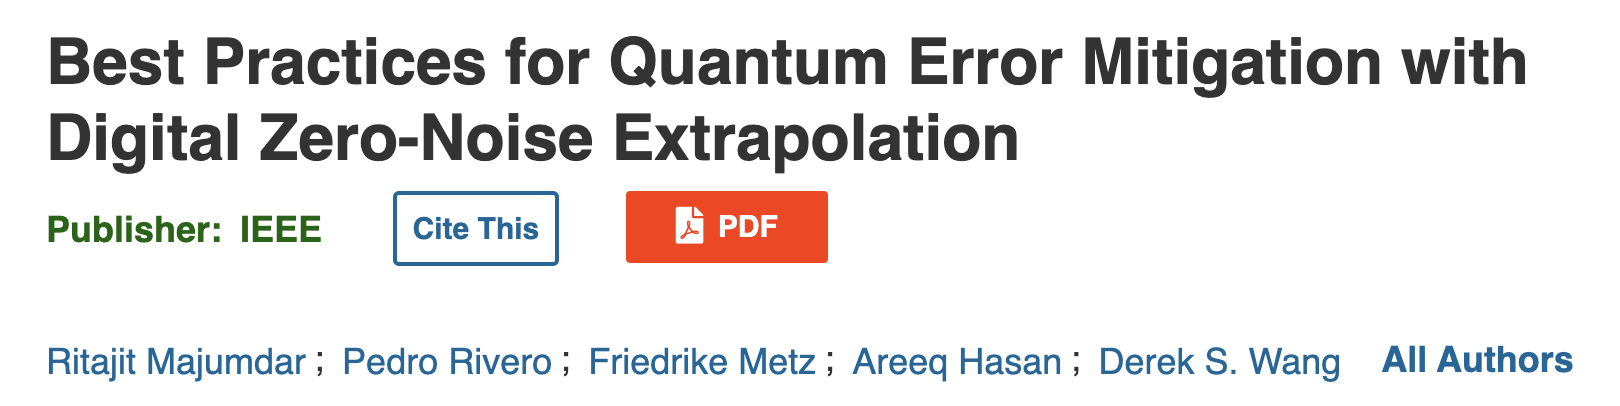

Much of the work that we wil be discussing here comes from original published research on [best practices for quantum error mitigation](https://arxiv.org/abs/2307.05203). Particualrly, we will focus on practical implementations of different error mitigation techniques. Please refer to the original references for comprehensive explanations, as we will only explain them briefly here.
- Transpilation
- Pauli Twirling (PT)
- Zero-noise extrapolation (ZNE)
- Dynamical decoupling (DD)
- Twirled Readout Error eXtinction (TREX)

## Circuit

### Transpilation

Transpilation is the process of rewriting a given input circuit to match the topology and native gate set of a specific quantum device, and/or to optimize the circuit for execution on present day noisy quantum systems. In other words, it allows to convert an input _virtual circuit_ into an output _physical circuit_ that can be executed directly on particular hardware. For details please visit [Qiskit's documentation](https://docs.quantum.ibm.com/api/qiskit/transpiler).

The first thing that we need is selecting the physical hardware to run things on:

In [9]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakePeekskill

SERVICE = QiskitRuntimeService()
BACKEND = SERVICE.backend("ibm_pinguino1")

We will then use Qiskit's `preset_passmanagers` to carry out transpilation easily. We will set `optimization_level=3` in order to optimize the physical circuits as much as possible, and `seed_transpiler=0` for reproducibility. Transpiling the circuit with a present pass manager creates a transpiled circuit which conforms to the instruction set archittecture (ISA), i.e., basis gates and coupling constraint, of a backend.

For example, after transpialtion the `reference_circuit` is re-written with the basis gates (`sx`, `x`, `rz`, and `ecr`) of the backend, and the two-qubit `ECR` gates appear between connected qubits.

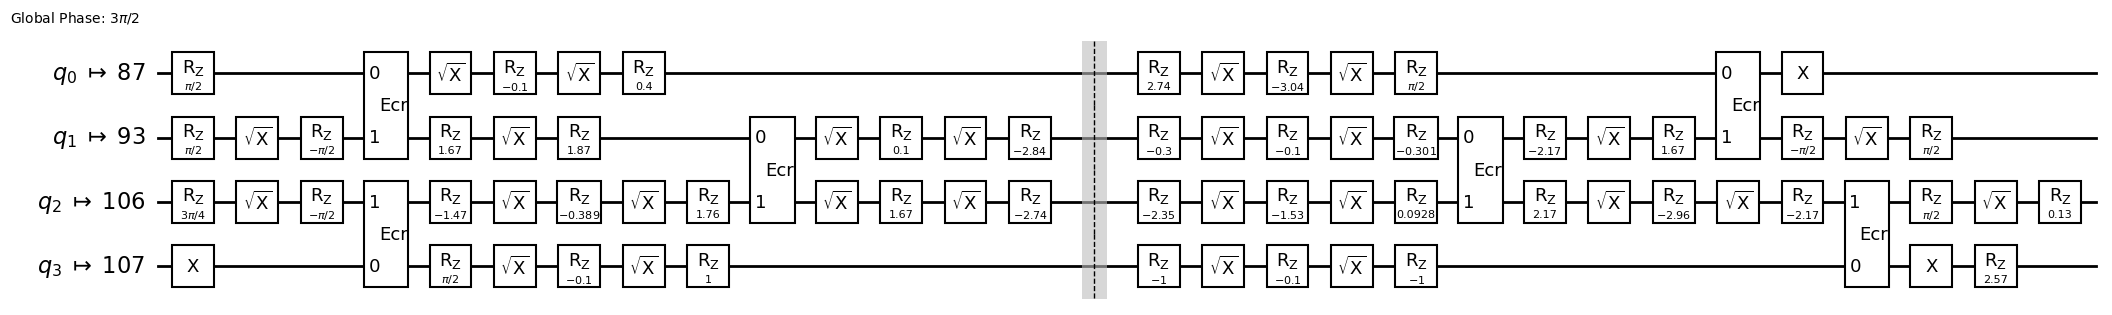

In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

TRANSPILATION = generate_preset_pass_manager(backend=BACKEND, optimization_level=3, seed_transpiler=0)

reference_circuit = TRANSPILATION.run(reference_circuit)
reference_circuit.draw("mpl", idle_wires=False, style="bw", fold=-1)

<div class="alert alert-block alert-info">
<b>NOTE</b>

IBM Eagle QPUs use _Echoed Cross Resonance_ (ECR) and latest IBM Heron QPUs  use _Controlled Z_ (CZ) gate as their native two-qubit gates respectively unlike previous devices which used CNOT.

Both ECR and CZ are equivalent to CNOT gate up to single qubit operations.
</div>

In [37]:
physical_circuit = TRANSPILATION.run(virtual_circuit)

<div class="alert alert-block alert-info">
<b>NOTE</b>
    
We will submit the above transpiled <code>physical_circuit</code> to Qiskit Runtime.
</div>

### Pauli twirling (PT)

[_Twirling_](https://www.zlatko-minev.com/blog/twirling) or _randomized compiling_ is a well known and widely used technique for converting arbitrary noise channels into other forms of noise. 

Pauli twirling is a special kind of twirling based on the Pauli set, and it has the effect of transforming any quantum channel into a Pauli channel. In and on itself, this has benefits when dealing, for instance, with coherent noise; since that tends to accumulate quadratically whereas Pauli noise accumulates linearly. Furthermore, Pauli channels offer secondhand benefits compared to other types of noise. For instance, thanks to Pauli noise being unital, it helps in the the extrapolation stage of ZNE by making quantum states tend towards the maximally mixed state somewhat monotonically. Since most of the errors in current quantum hardware come from two-qubit gates, this technique is often applied exclusively to (native) two-qubit gates.

In practice, Pauli Twirling is implemented by randomly substituting (noisy) gates for equivalent ones (i.e. representing the same unitary) made out of the original sandwhiched between Paulis. This is done over several randomizations leading to an ensemble of circuits to execute instead of only the original one. One can check through basic matrix algebra that there are a total of sixteen Pauli twirls for each of CZ, CNOT, and ECR gates —something to be expected sice both gates are Clifford. For instance:

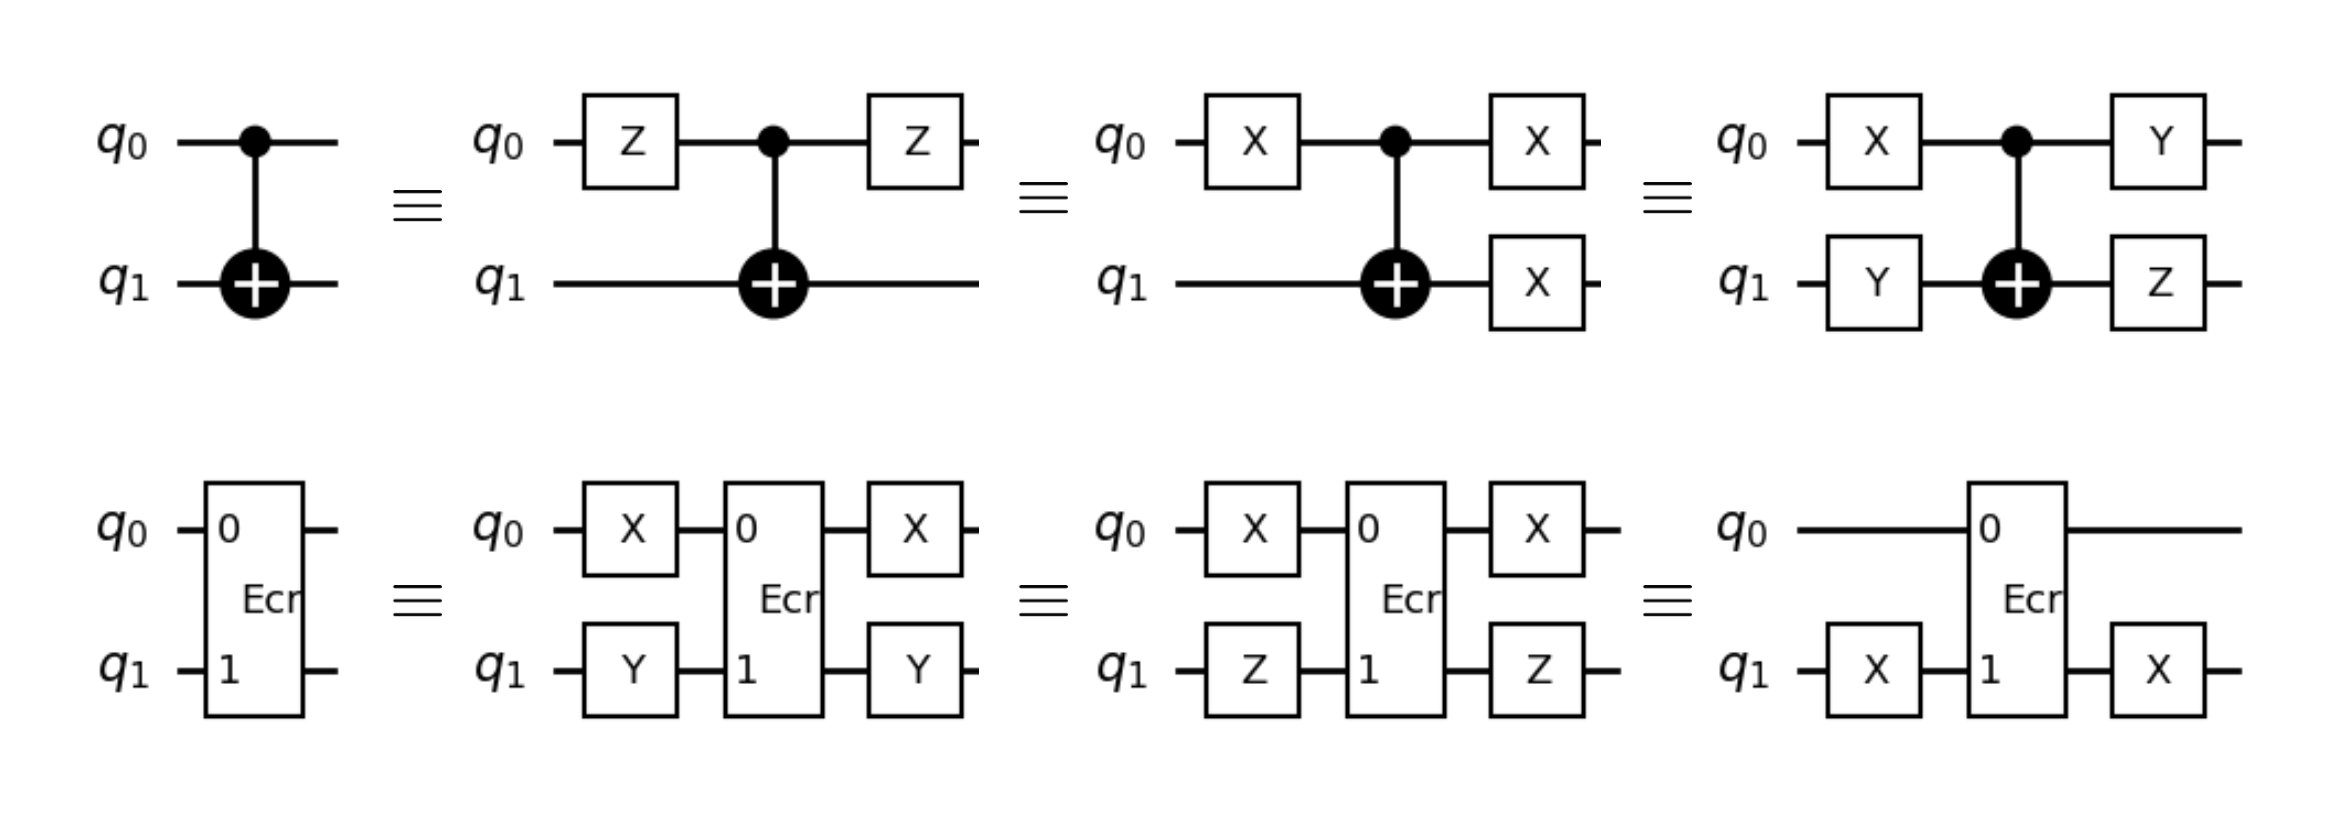

<div class="alert alert-block alert-warning">
<b>WARNING</b>
    
Use of custom <code>TwoQubitPauliTwirlPass</code> pass, Qiskit <code>PassManager</code>, and transpiler passes are for illustration purpose only. Our final submission to Qiskit Runtime can automatically handle twirling.
</div>

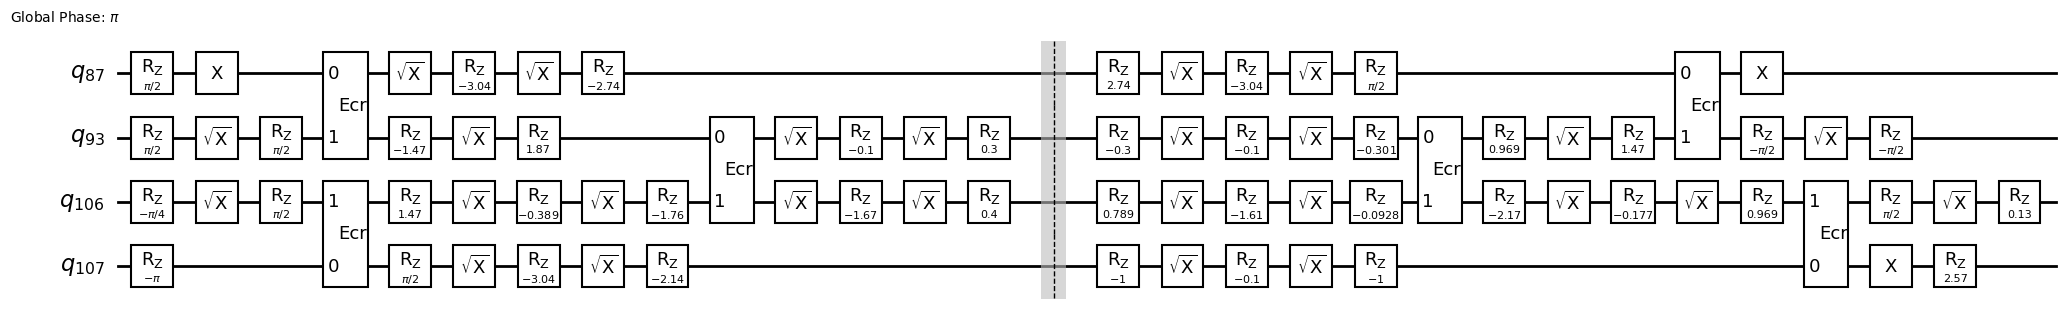

In [12]:
from quantum_enablement.mitigation import TwoQubitPauliTwirlPass
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Decompose, Optimize1qGatesDecomposition

PAULI_TWIRLING = PassManager([
    TwoQubitPauliTwirlPass(seed=0),
    Decompose('pauli'), 
    Optimize1qGatesDecomposition(BACKEND.operation_names),
])

example_circuit = PAULI_TWIRLING.run(reference_circuit)
example_circuit.draw("mpl", idle_wires=False, style="bw", fold=-1)

### Zero-noise extrapolation (ZNE)

Zero-noise extrapolation (ZNE) is an error mitigation technique that can be applied when computing expectation values from observables. This approach tends to reduce errors in expectation values, but is not guaranteed to produce an unbiased result. It is divided into two stages:
1. _Noise amplification_: the original quantum circuit is executed at different noise levels.
2. _Extrapolation_: from the noisy (expectation value) results the ideal result in the zero-noise limit is inferred.

While there are many ways to perform noise amplification, some of them can be tedious to implement or requiere low level access to hardware. Here we will use the _partial-folding_ strategy described in [best practices paper](https://arxiv.org/abs/2307.05203), which consist on replacing (two-qubit) gates $U$ with equivalent sequences of the form $U(U^\dagger U)^f$ to apply noise factors $\lambda(f) = 2f + 1$. This is particularly effective when the gates are _self-inverse_ (i.e. hermitian $U^\dagger = U$) as is the case with the CNOT and ECR gates.

Performing these substitions over a subset of gates allows to reach non-odd-integer noise factors. Furthermore, repeating this operation over several randomized subsets (i.e. resulting in an ensemble of circuits) has proven effective in attaining more precise results. We can use the [`prototype-zne` software package](https://pypi.org/project/prototype-zne/) to carry out this task easily.

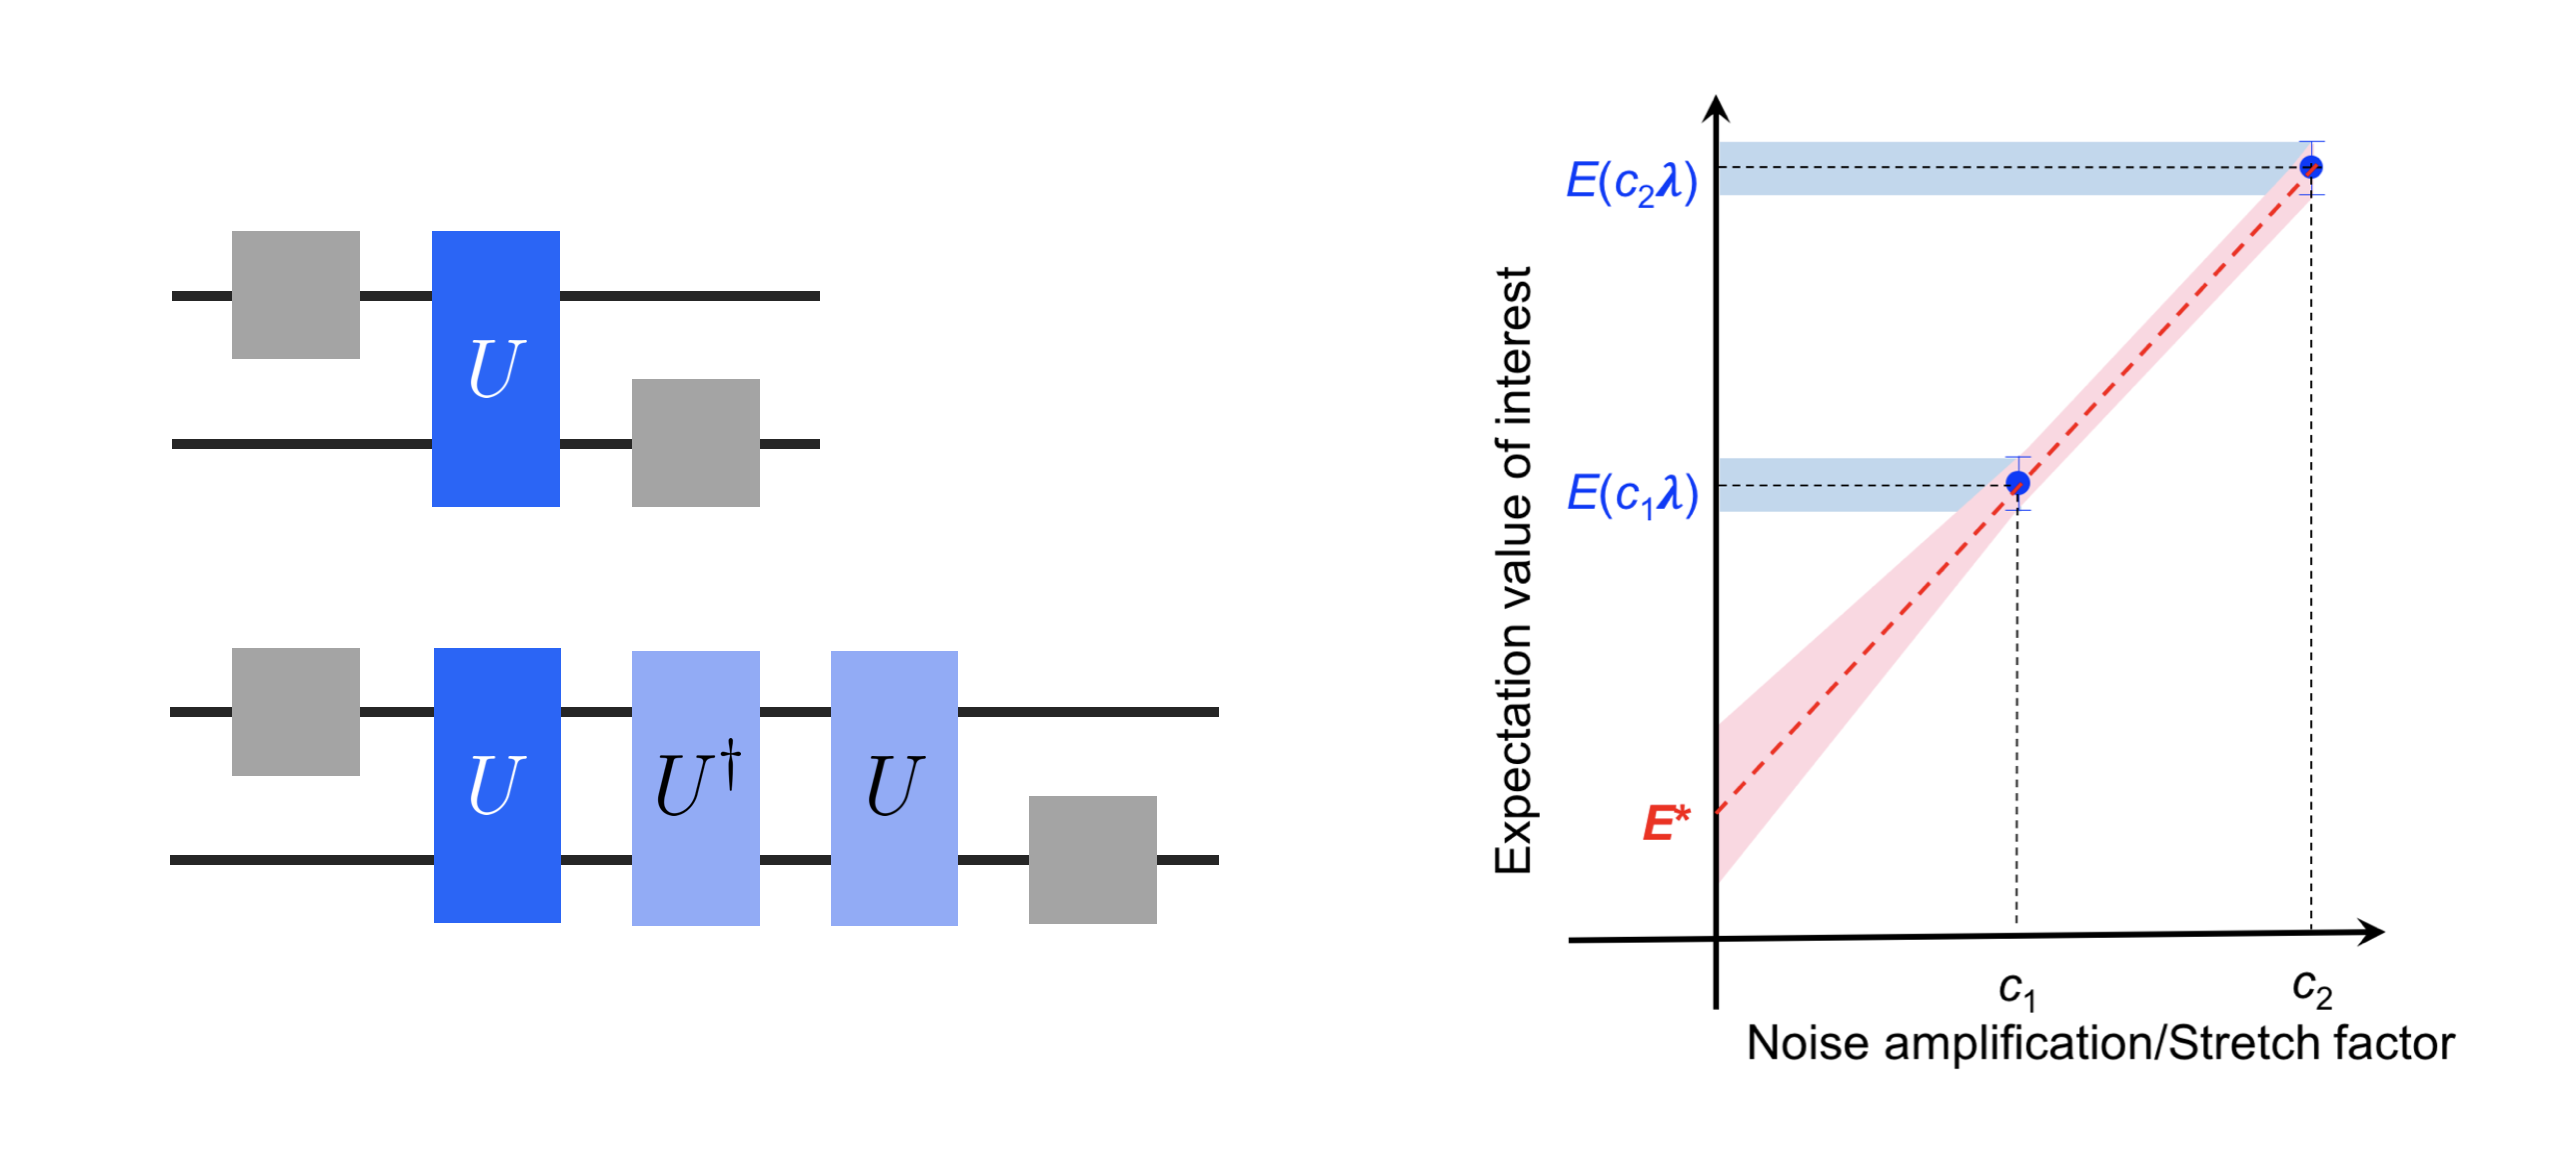

<div class="alert alert-block alert-warning">
<b>WARNING</b>

<a href="https://pypi.org/project/prototype-zne/">Prototype-ZNE</a> is used here for illustration purpose only. Qiskit Runtime has built-in ZNE, which we will leverage for our final submission.
</div>

In [13]:
from zne.noise_amplification import TwoQubitAmplifier

NOISE_AMPLIFIER = TwoQubitAmplifier(sub_folding_option='random', barriers=False, random_seed=0)

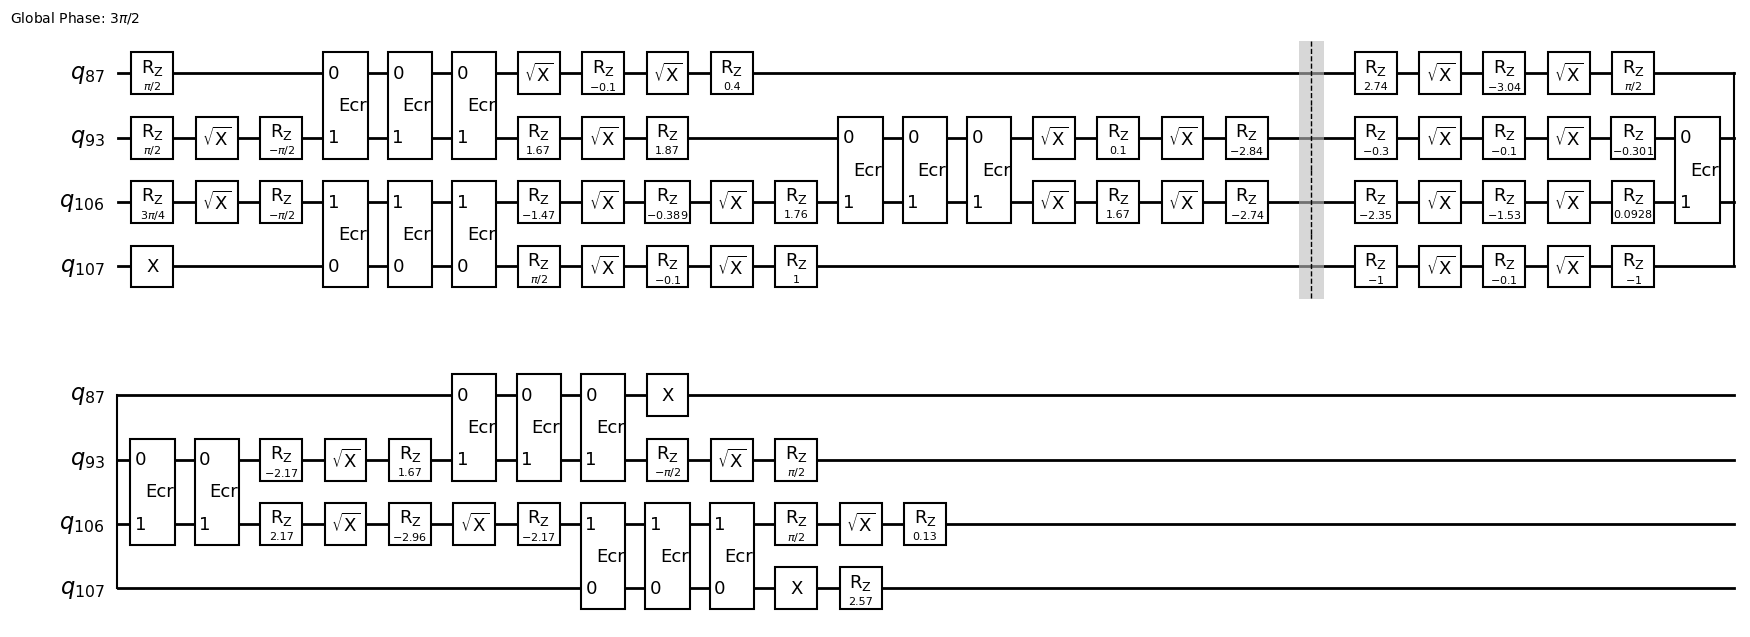

In [14]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import RemoveBarriers

NOISE_AMPLIFICATION = NOISE_AMPLIFIER.build_pass_manager(noise_factor=3)

example_circuit = NOISE_AMPLIFICATION.run(reference_circuit)
example_circuit.draw("mpl", idle_wires=False, style="bw")

### Dynamical decoupling (DD)

Quantum circuits are executed on IBM hardware as sequences of microwave pulses that need to be scheduled and run at precise time intervals. Let's take a look at this:

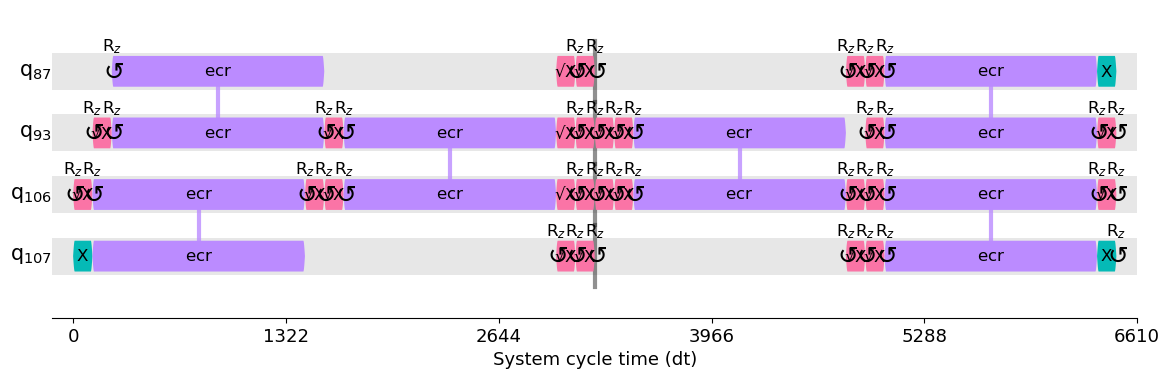

In [15]:
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDelay
from qiskit.visualization import timeline_drawer

SCHEDULING = PassManager([
    ALAPScheduleAnalysis(BACKEND.target.durations()), 
    PadDelay()
])

example_circuit = SCHEDULING.run(reference_circuit)
timeline_drawer(example_circuit, show_idle=False)

Unfortunately, qubits on the hardware can couple to each other and the induced _crosstalk_ effect can lead to coherent errors on idling qubits. Thefore having qubits waiting until the next pulse can be applied may result in larger error rates. To prevent this from happening, we can insert sequences of operations during those idle times as long as they amount to an identity. Different sequences will have different effects, and which sequence is better for each particular case remains an active area of research. This procedure is known in the literature as [_dynamical decoupling_ (DD)](https://arxiv.org/abs/2207.03670).

Furthermore, idle times will become larger after performing gate folding to increase the circuit's noise for ZNE. Therefore, for different noise factors it may be reasonable to use different DD sequences. In the interest of time, we leave this as an exercise for the reader, and limit ourselves to applying simple $XX$ sequences.

<div class="alert alert-block alert-warning">
<b>WARNING</b>

Manually adding <code>DD</code> sequences is shown for illustration purpose only. We will use Qiskit Runtime to include <code>DD</code> in our final runs.
</div>

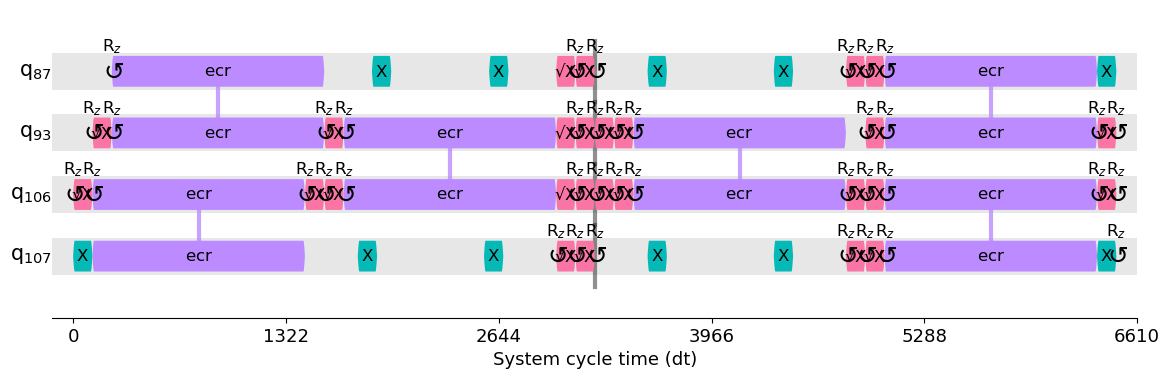

In [16]:
from qiskit.circuit.library import XGate
from qiskit.transpiler.passes import PadDynamicalDecoupling

DD_SEQUENCE = [XGate(), XGate()]
TARGET = BACKEND.target
PULSE_ALIGNEMENT = TARGET.timing_constraints().pulse_alignment

DYNAMICAL_DECOUPLING = PassManager([
    ALAPScheduleAnalysis(target=TARGET), 
    PadDynamicalDecoupling(dd_sequence=DD_SEQUENCE,target=TARGET,pulse_alignment=PULSE_ALIGNEMENT)
])

example_circuit = DYNAMICAL_DECOUPLING.run(reference_circuit)
timeline_drawer(example_circuit, show_idle=False)

### Twirled Readout Error eXtinction (TREX)

[Twirled readout error extinction (TREX)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.105.032620) is an efficient method for mitigating measurement errors on expectation value problems for Pauli observables. It is based on the notion of twirled measurements, which are accomplished by randomly substituting measurement gates by a sequence of (1) a Pauli-X gate, (2) a measurement, and (3) classical bit flip. Just like in standard gate twirling, this sequence amounts to the same as just a single measurement in the absence of noise; otherwise, it will have the effect of diagonalizing the readout-error transfer matrix, making it trivial to invert. To find such inverse, identity circuits with random measurement twirls need to be executed for calibration, which induces overhead on the quantum hardware.

## Observables

Now that we have the probability distributions associated to executions at different levels of noise, we can compute expecation values out of them.

For this we will look at two simple, yet representative, observables:

$$
\hat{O}_\text{singles} := \frac{1}{N}\sum_{q=0}^{N-1} Z_{q} \; , \quad
\hat{O}_\text{doubles} := \frac{1}{N}\sum_{q=0}^{N-1} Z_{q} Z_{q+1} \; ;
$$

capturing single qubit expecation values, and nearest-neighbor two-qubit correlations (i.e. w/ periodic boundary conditions) on average.

On top of them, we will also take a look at their average, which can be interpreted as a normalized _Ising model Hamiltonian_ (i.e. maximum energy equal to one):

$$
\hat{O}_\text{average} := 
\frac{1}{2N}\sum_{q=0}^{N-1} \left( Z_{q} + Z_{q} Z_{q+1} \right) \equiv
\hat{H}_\text{ising} \; .
$$

In [17]:
from collections import deque

from qiskit.quantum_info import SparsePauliOp

wt1 = deque(["I"] * (NUM_QUBITS - 1) + ["Z"])
wt2 = deque(["I"] * (NUM_QUBITS - 2) + ["Z", "Z"])

virtual_observable_wt1 = []
virtual_observable_wt2 = []
coeff = 1/(NUM_QUBITS)
for _ in range(NUM_QUBITS):
    wt1_term = "".join(literal for literal in wt1)
    wt2_term = "".join(literal for literal in wt2)
    
    virtual_observable_wt1.append((wt1_term, coeff))
    virtual_observable_wt2.append((wt2_term, coeff))
    
    wt1.rotate(-1)
    wt2.rotate(-1)
    
virtual_observable_wt1 = SparsePauliOp.from_list(virtual_observable_wt1)
virtual_observable_wt2 = SparsePauliOp.from_list(virtual_observable_wt2)

### Physical Observables

Like circuit, we need to transform observables to make them backend compatible. The `SparsePauliOp` object has a useful utility method named [`apply_layout`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.SparsePauliOp#apply_layout) to perform this transformation.

In [18]:
physical_observable_wt1 = virtual_observable_wt1.apply_layout(layout=physical_circuit.layout)
physical_observable_wt2 = virtual_observable_wt2.apply_layout(layout=physical_circuit.layout)

## Step 3: Execute using Qiskit Primitives

We can now submit our physical circuit and physical observables using Qiskit Runtime's [`Estimator`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) primitive to compute expectation values. We will use the built-in error suppression and mitigation features of `Estimator`, which are as easy as configuring some options. Next, we will show what mitigation options are available in the `Estimator` and how to configure those options to activate one or more mitigation methods together.

### EstimatorV2 Options

The following table shows the most commonly used [`EstimatorOptions`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.EstimatorOptions). The options are up-to-date as of Qiskit Runtime $0.22.0$ and may change in future. For a updated and comprehensive list refer to the [`Qiskit IBM Runtime API Docs`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/options).

| Options              | Sub-options              | Sub-sub-options         | Choices                                                                                   | Default                   |
|----------------------|--------------------------|-------------------------|-------------------------------------------------------------------------------------------|---------------------------|
| default_shots        |                          |                         |                                                                                           | `4096`                      |
| optimization_level   |                          |                         | `0`/`1`                                                                                       | `1`                         |
| resilience_level     |                          |                         | `0`/`1`/`2`                                                                                     | `1`                         |
| dynamical_decoupling | enable                   |                         |                                                                                           |                           |
|                      | sequence_type            |                         | `'XX'`/`'XpXm'`/`'XY4'`                                                                         | `'XX'`                      |
|                      | extra_slack_distribution |                         | `'middle'`/`'edges'`                                                                          | `'middle'`                  |
|                      | scheduling_method        |                         | `'asap'`/`'alap'`                                                                            | `'alap'`                    |
| resilience           | measure_mitigation       |                         | `True`/`False`                                                                                | `'True'`                      |
|                      | measure_noise_learning   | num_randomizations      |                                                                                           | `32`                      |
|                      |                          | shots_per_randomization |                                                                                           | 'auto'                    |
|                      | zne_mitigation           |                         | `True`/`False`                                                                                | `'False'`                     |
|                      | zne                      | noise_factors           |                                                                                           | `(1, 3, 5)`                 |
|                      |                          | extrapolator            | `'exponential'`/<br>`'linear'`/<br>`'double_exponential'`/<br>`'polynomial_degree_(1 <= k <= 7)'` | (`'exponential'`, `'linear'`) |
| twirling             | enable_gates             |                         | `'True'`/`'False'`                                                                                      | `False`                     |
|                      | enable_measure           |                         | `'True'`/`'False'`                                                                                      | `True`                      |
|                      | num_randomizations       |                         |                                                                                           | `'auto'`                    |
|                      | shots_per_randomization  |                         |                                                                                           | `'auto'`                    |
|                      | strategy                 |                         | `'active'`/<br>`'active-circuit'`/<br>`'active-accum'`/<br>`'all'`                                | `'active-accum'`            |

### Resilience Level Details

| Resilience Level | Definition                                                                                            | Technique                                                    |
|------------------|-------------------------------------------------------------------------------------------------------|--------------------------------------------------------------|
| 0                | No mitigation                                                                                         | None                                                         |
| 1 [Default]      | Minimal mitigation costs:<br>Mitigate error associated with readout errors                               | Twirled Readout Error eXtinction (TREX) measurement twirling |
| 2                | Medium mitigation costs. Typically reduces bias in estimators,<br>but is not guaranteed to be zero-bias. | Level 1 + Zero Noise Extrapolation (ZNE) and gate twirling   |

## Run jobs

<div class="alert alert-block alert-warning">
<b>WARNING</b>

We will only submit the transpiled <code>physical_circuit</code> (and <code>physical_observable_wt/wt2</code>) to Qiskit Runtime, which does not include the modifications by <code>DD</code>, <code>PT</code>, and <code>ZNE</code>. Appropriate Qiskit Runtime options will automatically take care of them, from circuit transformations to post-processing of results.
</div>

In [19]:
from qiskit_ibm_runtime import Batch, EstimatorV2 as Estimator

The [`run()`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2#run) method of an `Estimator` takes an iterable of `primitive unified blocs (PUBs)`. Each PUB is an iterable in the format `(single circuit, one or more observables, one or more parameter_values: Optional, precision: Optional)`.

In [20]:
pub = (physical_circuit, [physical_observable_wt1, physical_observable_wt2])

Next, we will submit multiple jobs with the same `pub` but with different combinations of error mitigations. Specifically, we will submit jobs for following $5$ cases:
1. No-mitigation
2. `DD`
3. `DD` + `TREX`
4. `DD` + `TREX` + (Gate) Twirling
5. `DD` + `TREX` + (Gate) Twirling + `ZNE`

As these jobs are non-iterative, we will use [`Batch`](https://docs.quantum.ibm.com/run/run-jobs-batch) execution mode of Qiskit Runtime. Submitting non-iterative jobs using `Batch` mode can parallelize classical part of the run (e.g., compilation) making them faster than running serially.

Refer to the [`docs`](https://docs.quantum.ibm.com/run) for other execution modes such as [`Session`](https://docs.quantum.ibm.com/run/run-jobs-in-session) for iterative jobs.

In [21]:
jobs = []
with Batch(backend=BACKEND):
    estimator = Estimator()

    # common options
    estimator.options.optimization_level = 0
    estimator.options.default_shots = 100_000

    # No-mitigation
    estimator.options.resilience_level = 0
    
    job0 = estimator.run(pubs=[pub])
    jobs.append(job0)

    # DD
    DD_sequence = "XX"
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = DD_sequence
    
    job1 = estimator.run(pubs=[pub])
    jobs.append(job1)

    # DD + TREX
    estimator.options.resilience_level = 1
    
    job2 = estimator.run(pubs=[pub])
    jobs.append(job2)

    # DD + TREX + Gate Twirling
    estimator.options.twirling.enable_gates = True
    # estimator.options.twirling.num_randomizations = 32 # uncomment to set your own `num_randomizations`
    
    job3 = estimator.run(pubs=[pub])
    jobs.append(job3)

    # DD + TREX + Gate Twirling + ZNE
    estimator.options.resilience_level = 2
    # estimator.options.resilience.zne.noise_factors = (1, 3, 5) # default. uncomment and edit as per your need
    # estimator.options.resilience.zne.extrapolator = ("exponential", "linear") # default. uncomment and edit as per your need
    
    job4 = estimator.run(pubs=[pub])
    jobs.append(job4)

Once the jobs are submitted, it is advised to get their IDs in order to track down the results:

In [22]:
for job in jobs:
    print(f"JOB IDs: {job.job_id()}")

JOB IDs: cramm91b98dg008b0fj0
JOB IDs: cramm997ay1g0081xcb0
JOB IDs: cramm9sfsz60008dk9zg
JOB IDs: cramma1w9jh0008zzyqg
JOB IDs: crammah2bcmg008zang0


On top of that, it is generally a good idea to generate a _unique reference_ to identify the execution. A (UTC) _timestamp_ is valuable for this among other things, and can easily be created automatically with the help of Python's builtin functions:

In [23]:
from datetime import datetime, timezone

TIMESTAMP = f'{datetime.now(timezone.utc).isoformat()}'
print(f">> Timestamp: {TIMESTAMP}")

>> Timestamp: 2024-04-09T14:01:14.806854+00:00


### Save experiment metadata

At this point we should be waiting for results to be returned from the servers connected to the quantum hardware; and we may possibly face some of the following:

- Long queues delaying the execution of our jobs.
- Large payloads taking a long time to run.
- Connection issues due to unstable networks or outages.

Therefore, it may be a good time to create a _checkpoint_. This will allow us to pick the work back up easily in the future. It will also facilitate later resubmission of failed jobs while keeping the results of those that succeeded —making our hardware usage more efficient.

Generally speaking, to create a checkpoint, you just need to store all the relevant information that allows you to recreate the current state of your work _exactly_ —or at least the parts of it that will be needed in later stages. We recommend storing additional helper metadata as well.

In [24]:
execution_data = {
    'timestamp': TIMESTAMP,
    'backend': BACKEND.name,
    'jobs': [job.job_id() for job in jobs],
    'shots': 100_000,
}

circuit_data = {
    'circuit': f'CU-MBL<{NUM_QUBITS}, {DEPTH}>({theta=:.5f}, {phis=})',
    'num_qubits': NUM_QUBITS,
    'depth': DEPTH,
    'initial_layout': physical_circuit.layout.initial_index_layout(filter_ancillas=True),
    'final_layout': physical_circuit.layout.final_index_layout(filter_ancillas=True),
}

mitigation_data ={
    'mitigation_techniques': {
        'job0': [],
        'job1': ['dd'],
        'job2': ['dd', 'trex'],
        'job3': ['dd', 'trex', 'twirling'],
        'job4': ['dd', 'trex', 'twirling', 'zne']
    },
    'num_randomizations': 32, # qiskit runtime default
    'noise_factors': (1, 3, 5), # qiskit runtime default
    'dd_sequence': DD_sequence,
}

METADATA = {**execution_data, **circuit_data, **mitigation_data}

We can easily dump all this information into a `.json` file:

In [25]:
from json import dump

FILENAME = f'{BACKEND.name}_{NUM_QUBITS}x{DEPTH}_{TIMESTAMP}.json'.replace(':', '.')  # Windows disallows ':' in filenames
with open(FILENAME, 'w') as file:
    checkpoint = {'metadata': METADATA}
    dump(checkpoint, file, indent=4)

print(f">> Checkpoint saved in: `{FILENAME}`")

>> Checkpoint saved in: `ibm_pinguino1_48x20_2024-04-09T14.01.14.806854+00.00.json`


## Step 4: Post-process

### Load experiment metadata

After some wait our [jobs have completed](https://quantum.ibm.com/jobs) and results are now ready! 

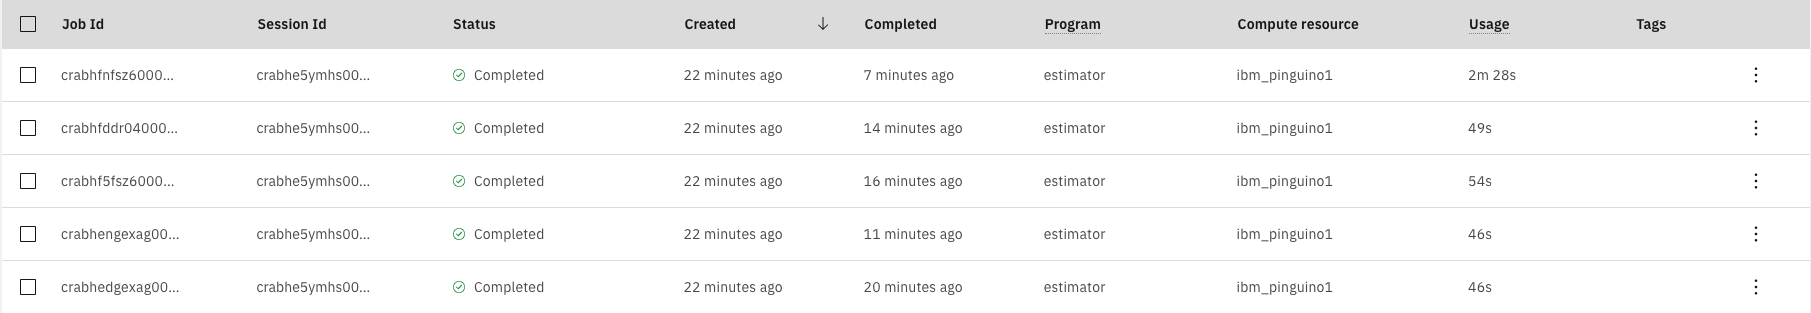

Let's reload our environment from the checkpoint in order to retrieve them:

In [26]:
from json import load

with open(FILENAME, 'r') as file:
    checkpoint = load(file)

In [27]:
METADATA = checkpoint.get('metadata')

NUM_QUBITS = METADATA.get('num_qubits')
DEPTH = METADATA.get('depth')
NUM_RANDOMIZATIONS = METADATA.get('num_randomizations')
NOISE_FACTORS = METADATA.get('noise_factors')

### Retrieve and unpack results

In [28]:
from qiskit_ibm_runtime import QiskitRuntimeService

SERVICE = QiskitRuntimeService()
jobs = [SERVICE.job(id) for id in METADATA.get('jobs')]

We can now fetch the results:

In [29]:
primitive_results = [job.result() for job in jobs]

Each [`PrimitiveResults`](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.PrimitiveResult#primitiveresult) object has a list-like structure holding [`PubResult`s](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.PubResult#pubresult). Common metadata is also available in the `PrimitiveResult`.

In [30]:
primitive_results[0]

PrimitiveResult([PubResult(data=DataBin<2>(evs=[0.65404667 0.52762417], stds=[0.00033856 0.00038273], ensemble_standard_error=[0.00033856 0.00038273]), metadata={'shots': 100000, 'target_precision': 0.003162277660168379, 'circuit_metadata': {}, 'num_randomizations': 1})], metadata={'version': 2})

The `PubResult` object again has two fields: `data` and `metadata`. The `data` (`DataBin`) container holds our expectation values as `evs` and standared deviations of corresponding expectation values in `stds`.

In [31]:
pub_result_0 = primitive_results[0][0]
pub_result_0

PubResult(data=DataBin<2>(evs=[0.65404667 0.52762417], stds=[0.00033856 0.00038273], ensemble_standard_error=[0.00033856 0.00038273]), metadata={'shots': 100000, 'target_precision': 0.003162277660168379, 'circuit_metadata': {}, 'num_randomizations': 1})

The `PubResult.data.evs` array in our case contains two values where one corresponds to the `weight-1` observable and the other is for `weight-2` observable. We will fetch the expectation values from the data container and separate them in two different arrays for ease of processing.

In [32]:
pub_result_0.data.evs.shape

(2,)

In [33]:
expvals_wt1 = np.array([result[0].data.evs.item(0) for result in primitive_results])
expvals_wt2 = np.array([result[0].data.evs.item(1) for result in primitive_results])

stds_wt1 = np.array([result[0].data.stds.item(0) for result in primitive_results])
stds_wt2 = np.array([result[0].data.stds.item(1) for result in primitive_results])

In [34]:
expvals_avg = (expvals_wt1 + expvals_wt2)/2

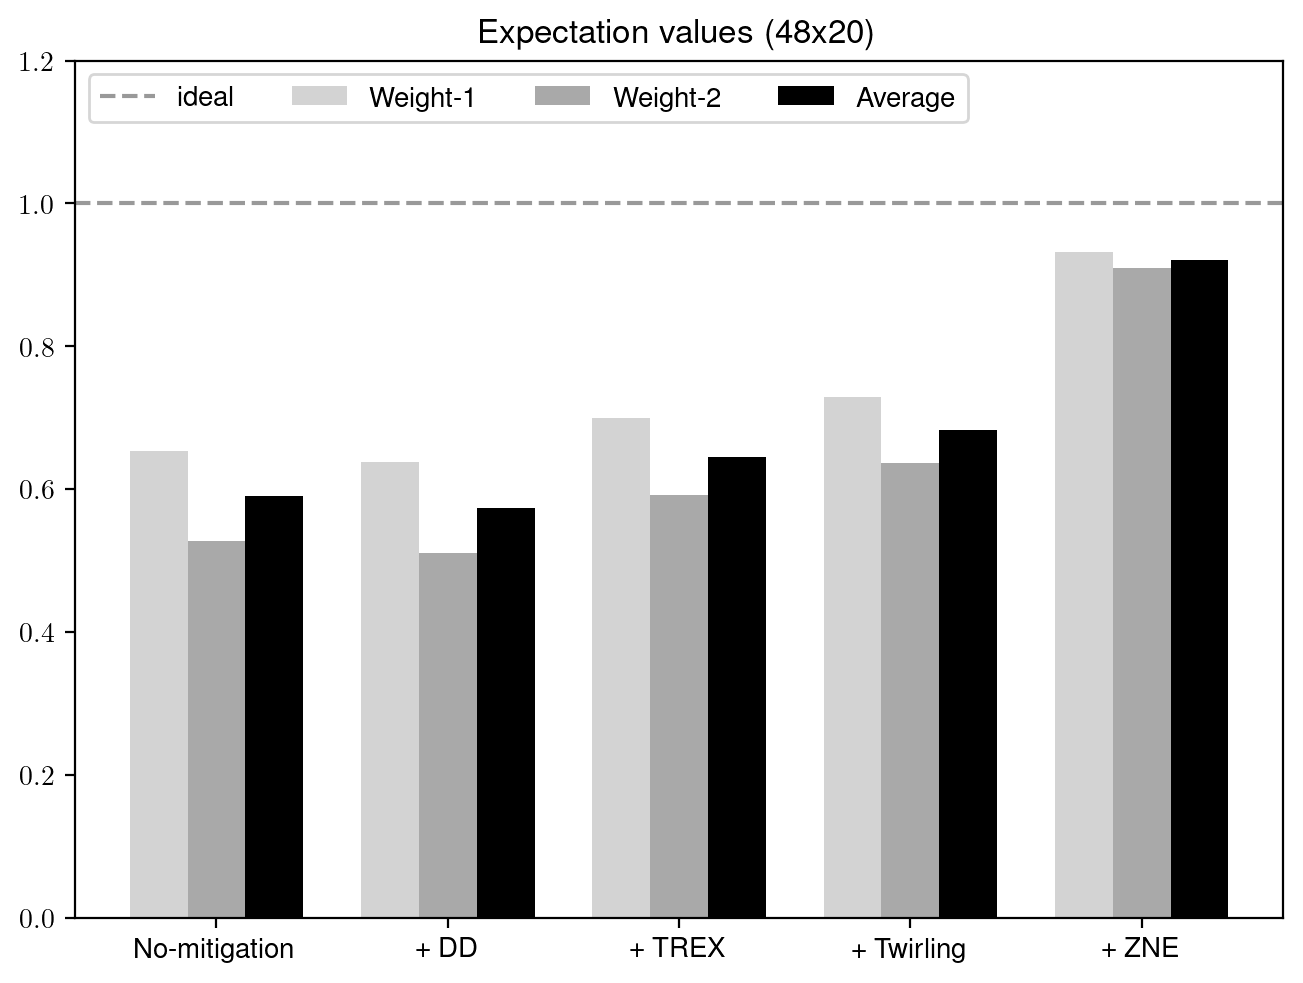

In [35]:
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})

fig, ax = plt.subplots(dpi=200, layout='constrained')

width = 0.25
labels = ['No-mitigation', '+ DD', '+ TREX', '+ Twirling', '+ ZNE']
x = np.arange(len(labels)) 

ax.bar(x - width, expvals_wt1, width, label='Weight-1', color='lightgrey')
ax.bar(x, expvals_wt2, width, label='Weight-2', color='darkgray')
ax.bar(x + width, expvals_avg, width, label='Average', color='k')

ax.axhline(y=1.0, color='k', linestyle='--', label="ideal", alpha=0.4)
ax.set_ylim([0.0, 1.2])
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left', ncols=4)
ax.set_title(f"Expectation values ({NUM_QUBITS}x{DEPTH})")

plt.show()

The MBL circuit has dense a structure, where qubits have little to none idle times bteween gates. Therefore, turning on `Dynamical Decoupling` did not bring improvement as the difference between `no-mitigation` and `DD` is almost imperceptible in the above plot. 

### Save experiment data

We may want to save these results locally for ease of access, to share them, or to work offline. A new checkpoint with additional information can be created for this, either overriding the previous file or not:

In [36]:
from json import dump

FILENAME = FILENAME  # Update previous file
with open(FILENAME, 'w') as file:
    checkpoint = {
        'metadata': METADATA, 
        'results': {
            'evs': {
                'weight-1': expvals_wt1.tolist(),
                'weight-2': expvals_wt2.tolist(),
                'avg': expvals_avg.tolist(),
            },
            'stds': {
                'weight-1': stds_wt1.tolist(),
                'weight-2': stds_wt2.tolist(),
            }
        }
    }
    dump(checkpoint, file, indent=4)

print(f">> Checkpoint saved in: `{FILENAME}`")

>> Checkpoint saved in: `ibm_pinguino1_48x20_2024-04-09T14.01.14.806854+00.00.json`


<div class="alert alert-block alert-warning">
<b>WARNING</b>
    
For the sake of simplicity in the present Notebook we only focus on expectation values.
Nevertheless, a more complete statistical description will necessarily incorporate information about the resulting *standard error*. 
</div>

# Annex

## Acknowledgements

- **Derek Wang**: for scientific insight and guidance on MBL research.

## References

1. Majumdar et al, _Best practices for quantum error mitigation with digital zero-noise extrapolation_, [IEEE Xplore](https://ieeexplore.ieee.org/document/10313813)
2. Kim et al., _Evidence for the utility of quantum computing before fault tolerance_, [Nature 618, 500–505 (2023)](https://doi.org/10.1038/s41586-023-06096-3)
3. Shtanko et al., _Uncovering Local Integrability in Quantum Many-Body Dynamics_, [ArXiV:2307.07552](https://arxiv.org/abs/2307.07552)
4. Fahri et al., _A Quantum Approximate Optimization Algorithm_, [ArXiV:1411.4028](https://arxiv.org/abs/1411.4028)
5. Temme et al., _Error mitigation for short-depth quantum circuits_, [Phys. Rev. Lett. 119, 180509](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.180509)
6. _(TREX) Model-free readout-error mitigation for quantum expectation values_, [Phys. Rev. A 105, 032620](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.105.032620)
7. Ezzell et al., _Dynamical decoupling for superconducting qubits: a performance survey_, [ArXiV:2207.03670](https://arxiv.org/abs/2207.03670)
8. Lidar, _Review of Decoherence Free Subspaces, Noiseless Subsystems, and Dynamical Decoupling_, [ArXiV:1208.5791](https://arxiv.org/abs/1208.5791)
9. Wallman et al., _Noise tailoring for scalable quantum computation via randomized compiling_, [Phys. Rev. A 94, 052325](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.94.052325)
10. Minev, _A tutorial on tailoring quantum noise - Twirling 101_, [Online](https://www.zlatko-minev.com/blog/twirling)
11. Di Matteo, _A short introduction to unitary 2-designs_, [Online](https://glassnotes.github.io/OliviaDiMatteo-Unitary2Designs.pdf)
12. _Qiskit: An Open-source Framework for Quantum Computing_, [PyPI](https://pypi.org/project/qiskit/)
13. Rivero et al., _Zero-noise extrapolation prototype_, [PyPI](https://pypi.org/project/prototype-zne/)

## Appendices

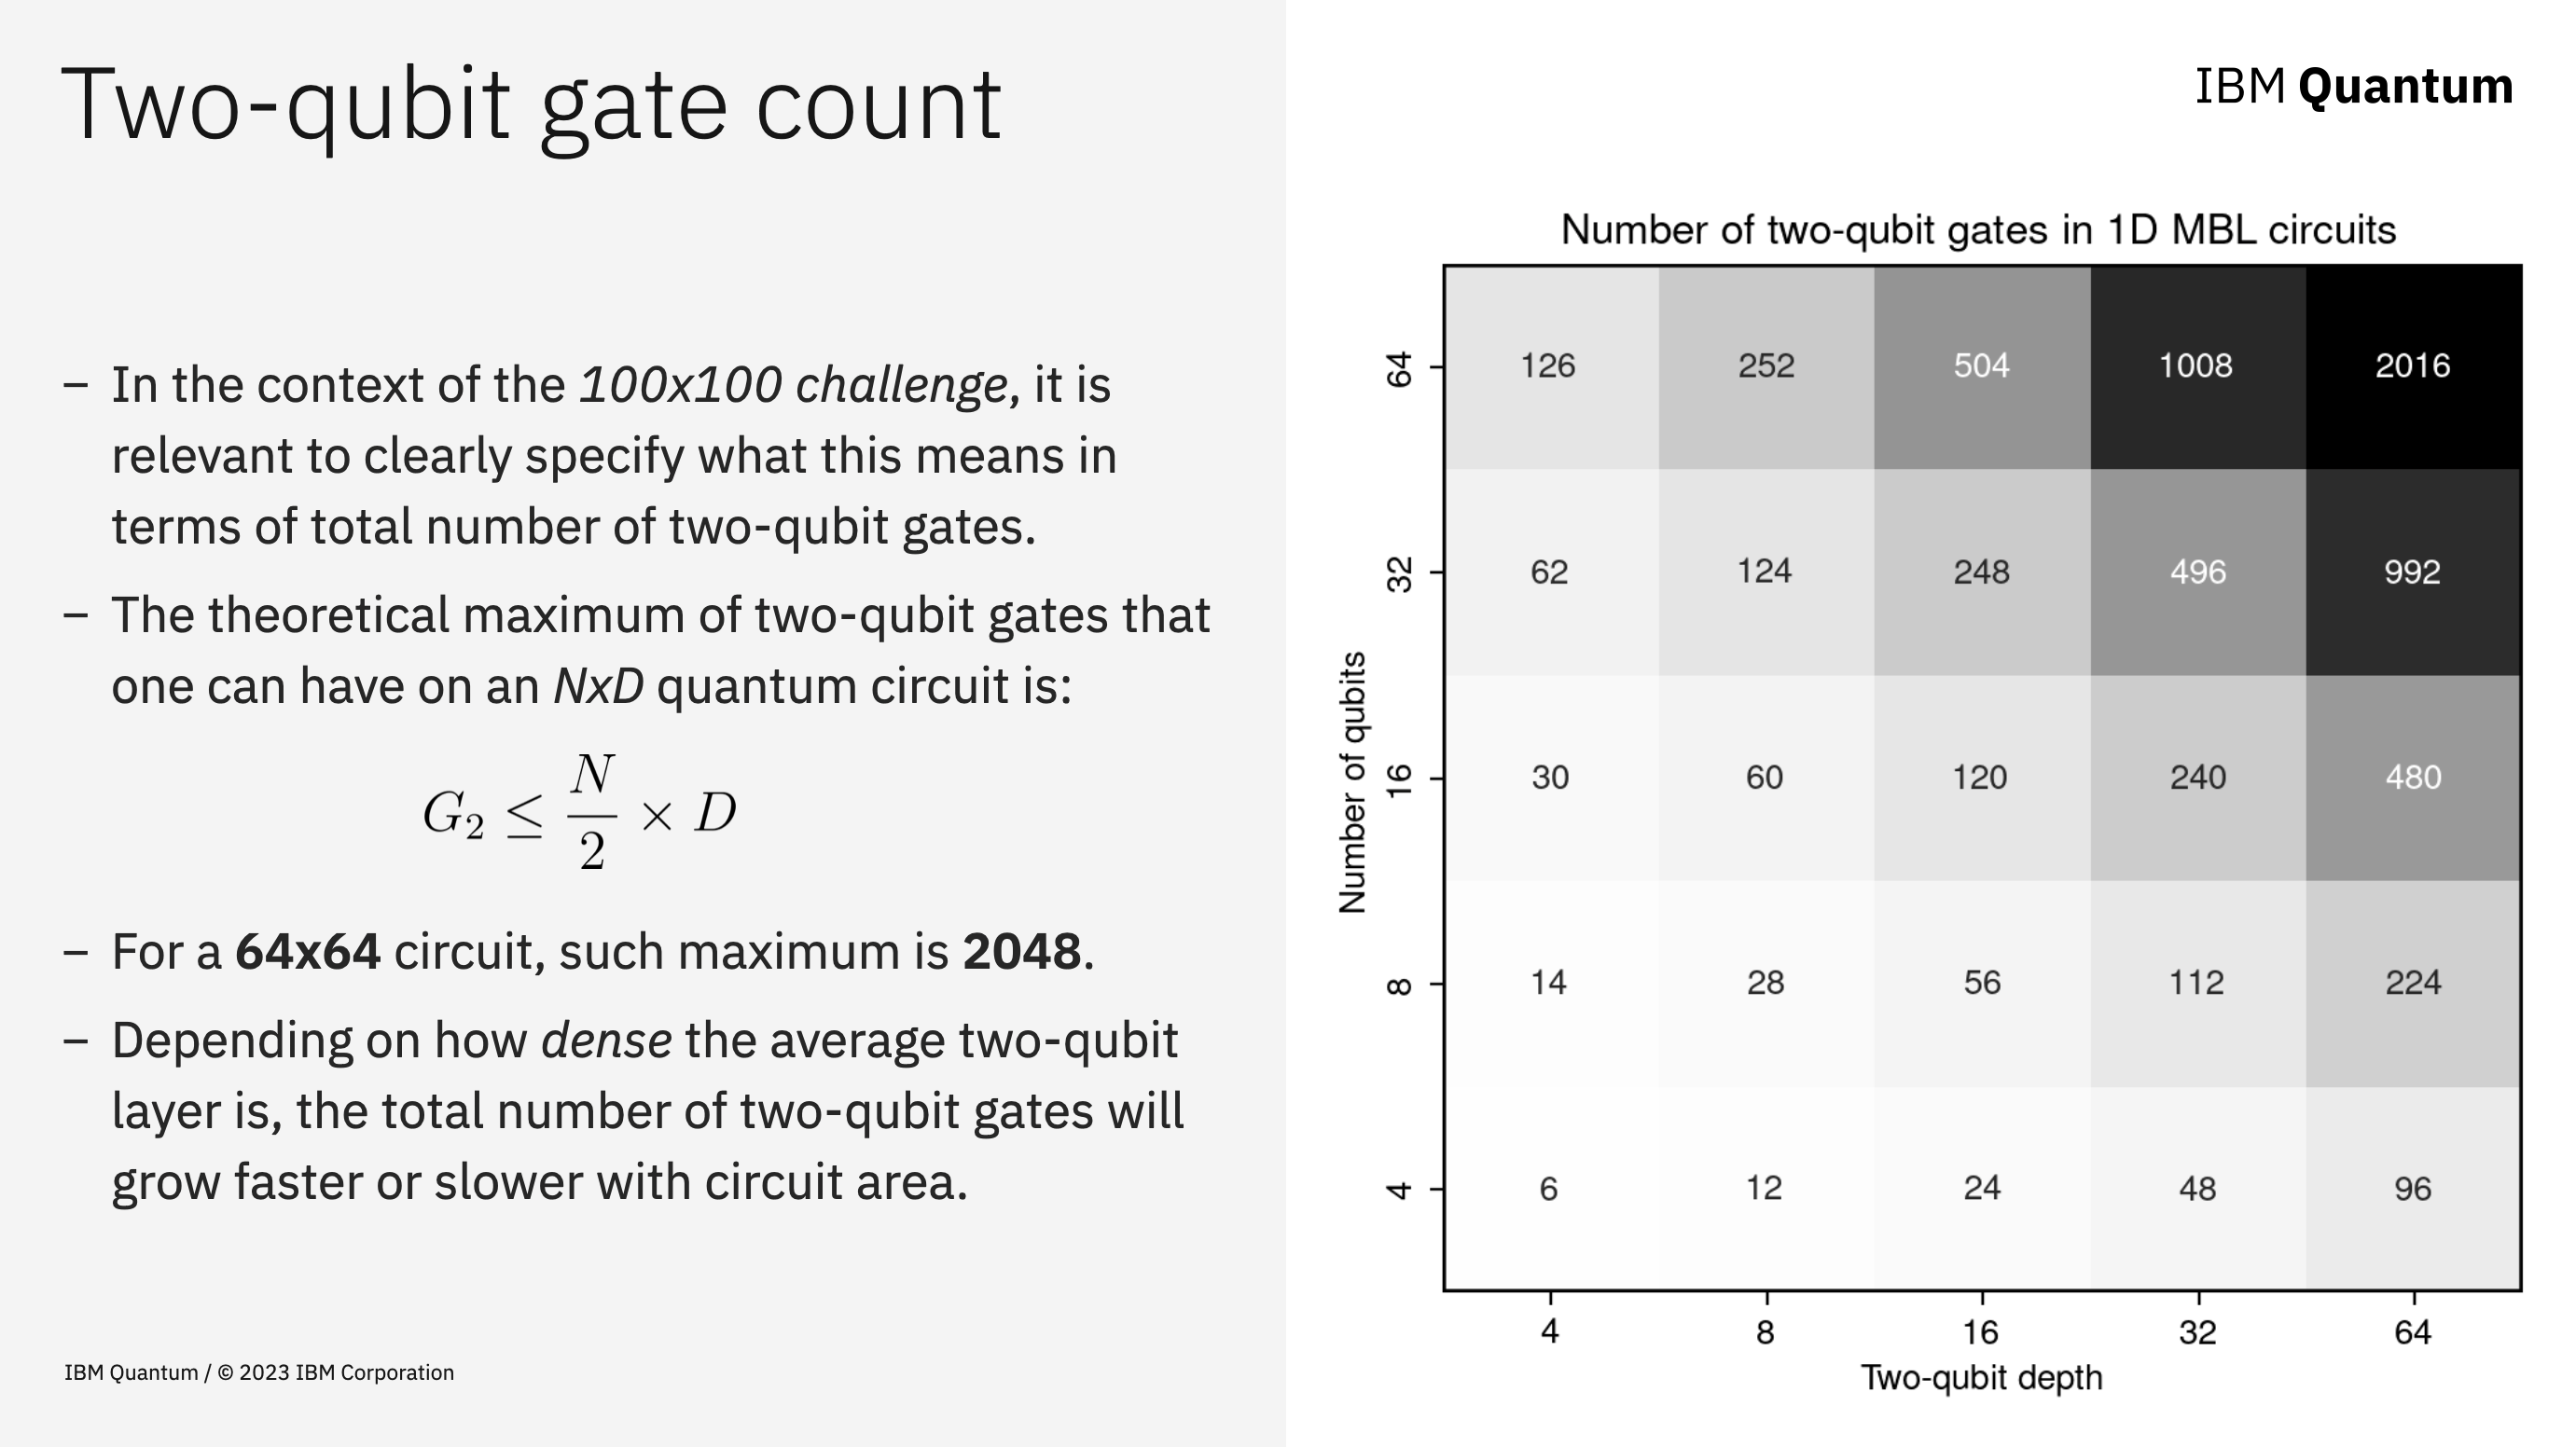

## Software dependencies

```
quantum-enablement @ git+https://github.com/IBM-Quantum-Technical-Enablement/quantum-enablement
qiskit[visualization] >= 1.0.0
qiskit-ibm-runtime >= 0.22.0
```

---